In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qat.lang.AQASM import AbstractGate, Program
from qat.core.console import display

In [3]:
def Loteria(n):
    #Max number of elememnts I can generate
    N_max = 2**n
    print('N_max: {}'.format(N_max))
    #Generate winner number
    Winner = np.random.randint(N_max)
    print('Winner: {}'.format(Winner))
    return Winner#, ToBinnary(Winner, n)

In [4]:
def TensorialHaddamard(n):
    """
    Rutina que implementa una Puerta Hadamard n tensorial
    """
    from qat.lang.AQASM import QRoutine, H
    tensorialHadamard = QRoutine()
    qbits=tensorialHadamard.new_wires(n)
    for i in range(n):
        tensorialHadamard.apply(H,qbits[i])
    return tensorialHadamard
#Creo una puerta utilizando el circuito
TensorialHaddamard_Gate = AbstractGate(
    "HaddamardTensorial", 
    [int], 
    circuit_generator=TensorialHaddamard,
    arity = lambda x: x
)

def Reflection(n, state, Positive=True):
    """
    Implementa una matriz de reflexion de dimensión n en torno a un estado dado.
    Positive:
        * True: I-2|w><w|
        * False: 2|w><w|-I
    """
    #Matriz Identidad
    Identity = np.identity(2**n)
    Identity[state, state] =-1
    if Positive:
        return Identity
    else:
        return -Identity
#Creo una puerta utilizando el circuito    
Reflexion_Gate = AbstractGate(
    "Reflexion", 
    [int, int, bool], 
    matrix_generator=Reflection,
    arity = lambda x, y, z: x
)

def Difusor(n):
    """
    Rutina que implementa el Difusor en n dimensiones
    """        
    from qat.lang.AQASM import QRoutine
    Difusor_rout = QRoutine()
    wires = Difusor_rout.new_wires(n)
    #Aplicamos n Hadamard
    Difusor_rout.apply(TensorialHaddamard_Gate(n),wires)
    Difusor_rout.apply(Reflexion_Gate(n, 0, False),wires)
    Difusor_rout.apply(TensorialHaddamard_Gate(n),wires)
    return Difusor_rout
#Creo una puerta utilizando el circuito
Difusor_Gate = AbstractGate(
    "Difusor", 
    [int], 
    circuit_generator=Difusor,
    arity = lambda x: x
)

def Grover(n, state, r):
    """
    Implementa r iteraciones Grover
    n: number of qbits
    state: number with the winner state
    r: number of applications of Grover operator
    """
    from qat.lang.AQASM import QRoutine
    Grover_rout = QRoutine()
    wires = Grover_rout.new_wires(n)
    for i in range(r):
        Grover_rout.apply(Reflexion_Gate(n, state, True),wires)
        Grover_rout.apply(Difusor_Gate(n),wires)
    return Grover_rout
#Creo una puerta utilizando el circuito
Grover_Gate = AbstractGate(
    "Grover", 
    [int, int, int ], 
    circuit_generator=Grover,
    arity = lambda x, y, z: x
)


def DoAGrover(n, Winner, r):
    """
    Implementa un algoritmo Grover con r iteraciones
    """
    if r >0:
        #Definimos el circuito
        Circuit = Program()
        #Reservamos los qbits que queremos
        qbits = Circuit.qalloc(n)
        #Generamos una superposición equiprobable de estados
        Circuit.apply(TensorialHaddamard_Gate(n),qbits)
        Circuit.apply(Grover_Gate(n, Winner, r),qbits)
        return Circuit
    else:
        raise ValueError('EL numero de iteraciones del algoritmo de Grover debe ser mayor que 0')

In [7]:
def OptimalGrover(n):
    """
    En base al numero de qbits calcula el angulo de rotación de una iteración Grover
    y el numero optimo de iteraciones Grover para maximizar la probabilidad
    """
    #Rotation angle for Glover Algorithm
    Theta = 2*np.arcsin(np.sqrt(1/(2**n)))    
    #Number of times for application of Grover Algorithm
    r = (np.pi/(2*Theta))-0.5
    return int(np.round(r))

def Do(n, state, r):
    Circuit = Program()
    qbits = Circuit.qalloc(n)
    Circuit.apply(TensorialHaddamard_Gate(n),qbits)
    for i in range(r):
        Circuit.apply(Reflexion_Gate(n, state, True),qbits)
        Circuit.apply(Difusor_Gate(n),qbits)
        
    from qat.qpus import LinAlg
    linalgqpu = LinAlg()
    Job = Circuit.to_circ().to_job(nbshots=1)
    result = linalgqpu.submit(Job)
    Solucion=str(result[0].state)m
    SolucionDecimal = int(Solucion.replace('|','').replace('>', ''),2)
    #print('SolucionDecimal: {}'.format(SolucionDecimal))
    if SolucionDecimal == state:
        return True
    else:
        return False   

In [139]:
def Probabilities4Groover(n, state, r):
    """
    Calcula las probabilidades de r iteraciones  Groover
    """
    Circuit = DoAGrover(n, state, r)
    from qat.qpus import LinAlg
    linalgqpu = LinAlg()
    Job = Circuit.to_circ().to_job()
    result = linalgqpu.submit(Job)
    States = []
    Probabilities =[]
    DecimalNumbers = []
    #Para ver como funciona calculamos todos los estados posibles
    #Y sus probabilidades asociadas

    for sample in result:
        States.append(str(sample.state).replace('|','').replace('>', ''))
        #Probabilidad del estado
        Probabilities.append(np.absolute(sample.amplitude)**2)
        DecimalNumbers.append(int(str(sample.state).replace('|','').replace('>', ''),2))
    return Probabilities, States, DecimalNumbers
    #Buscamos el Estado con la mayor probabilidad
    #idMax = Probabilities.index(max(Probabilities))
    #Ganador=str(States[idMax]).replace('|','').replace('>', '')
    #print('Estado con la mayor Probabilidad: {} -> {}. Probabilidad: {}'.format(
    #    Ganador, int(Ganador,2), Probabilities[idMax]))  
    
def GroverRoutine(n, state, r):
    """
    Obtiene una medida de r iteraciones Groover 
    """
    Circuit = DoAGrover(n, state, r)
    #Le pido una medida
    from qat.qpus import LinAlg
    linalgqpu = LinAlg()
    Job4Groover = Circuit.to_circ().to_job(nbshots=1)
    result = linalgqpu.submit(Job4Groover)
    Solucion=str(result[0].state)
    SolucionDecimal = int(Solucion.replace('|','').replace('>', ''),2)
    #print('SolucionDecimal: {}'.format(SolucionDecimal))
    if SolucionDecimal == state:
        return True
    else:
        return False       

Vamos a comprobar que todo funciona bien. Para ello fijamos un número de Qbits y vamos a hacer un barrido en el número de iteraciones Grover y registramos la probabilidad de obtener el elemento ganador. Podemos generar un gráfico Probabilidad vs iteraciones y comprobamos que el máximo está donde tiene que estar (lo calculamos llamando a la función OptimalGrover)

In [35]:
NumberOfQbits = 'll'
Probs = []
Max = []
NumberOfQbits = []
for nq in range(2, 11):
    NumberOfQbits.append(nq)
    Winner = Loteria(nq)
    OptimalIterations = OptimalGrover(nq)
    Max.append(OptimalIterations)
    print('Iteraciones óptimas: {}'.format(OptimalIterations))
    WinnerProbabilities = []
    for i in range(1, 2*OptimalIterations+1):
        prob, state, numbers = Probabilities4Groover(nq, Winner, i)
        #Obtengo la probabilidad del numero ganador
        WinnerProbabilities.append(prob[numbers.index(Winner)])
    Probs.append(WinnerProbabilities)
    
        
    
Data = pd.DataFrame(Probs, index=NumberOfQbits).T    
Data.index=range(1, len(Data)+1)

N_max: 4
Winner: 1
Iteraciones óptimas: 1
N_max: 8
Winner: 1
Iteraciones óptimas: 2
N_max: 16
Winner: 8
Iteraciones óptimas: 3
N_max: 32
Winner: 30
Iteraciones óptimas: 4
N_max: 64
Winner: 56
Iteraciones óptimas: 6
N_max: 128
Winner: 54
Iteraciones óptimas: 8
N_max: 256
Winner: 249
Iteraciones óptimas: 12
N_max: 512
Winner: 52
Iteraciones óptimas: 17
N_max: 1024
Winner: 903
Iteraciones óptimas: 25


In [36]:
import pandas as pd

In [56]:
Data = pd.DataFrame(Probs, index=NumberOfQbits).T   
Data.index=range(1, len(Data)+1)


In [71]:
MaximosTeoricos = pd.Series(Max, index=range(2, len(Max)+2))

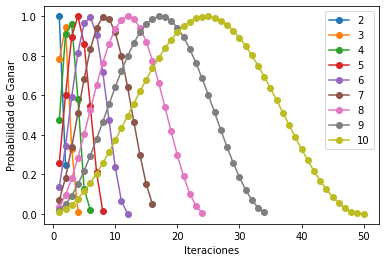

In [57]:
for columns in Data.columns:
    plt.plot(Data[columns], 'o-')
plt.xlabel('Iteraciones')    
plt.ylabel('Probabilidad de Ganar')  
plt.legend(Data.columns)

In [74]:
#Localizacion de los másximos experimentales
Data.idxmax(axis=0)

2      1
3      2
4      3
5      4
6      6
7      8
8     12
9     17
10    25
dtype: int64

In [75]:
#Localizacion de los máximos teóricos
MaximosTeoricos

2      1
3      2
4      3
5      4
6      6
7      8
8     12
9     17
10    25
dtype: int64

In [76]:
Data.idxmax(axis=0) == MaximosTeoricos

2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
dtype: bool

Parece que está bien implementado

## Rutina Groover

La función **GroverRoutine** lo que hace es a partir de un número de Qbits y del elemento ganador montar un algoritmo Grover que se ejucutará r veces. A continuación hace una sola medida y la compara con la del número ganador y devuelve True o False en función de si acierta o no. 
Vamos a comparar la rutina cuántica y la clásica

In [131]:
def GroverRoutine(n, Winner, r):
    Circuit = DoAGrover(n, Winner, r)
    #Le pido una medida
    from qat.qpus import LinAlg
    linalgqpu = LinAlg()
    Job4Groover = Circuit.to_circ().to_job(nbshots=1)
    result = linalgqpu.submit(Job4Groover)
    Solucion=str(result[0].state)
    SolucionDecimal = int(Solucion.replace('|','').replace('>', ''),2)
    #print('SolucionDecimal: {}'.format(SolucionDecimal))
    if SolucionDecimal == Winner:
        return True
    else:
        return False   

In [145]:
max(Probabilities4Groover(8, Winner, 12)[0])

0.9999470421032387

In [138]:
int(str(GroverRoutine(8, Winner, 6)[0].state).replace('|','').replace('>', ''),2)

TypeError: 'bool' object is not subscriptable

In [78]:
def Oraculo(asked, winner):
    #print('Your Input is: {}'.format(asked))
    if asked == winner:
        print('You Win')
        return True
    else:
        #print('You Lose')
        return False
def GetNumber01(N, winner):
    i=0
    Continue = True
    NumberOfAsks = 0
    while Continue:
        Condition = Oraculo(i, winner)
        NumberOfAsks = NumberOfAsks +1
        i=i+1
        if Condition:
            Continue = False
        if NumberOfAsks > 2**N:
            print('Algo salio mal')
            Continue = False
    print('Number Of Questions :{}'.format(NumberOfAsks)) 
    return NumberOfAsks   

In [132]:
def LoopGrover(n, Winner):
    i=1
    Continue = True    
    while Continue:
        print(i)
        Condition = GroverRoutine(n, Winner, i)
        print(Condition)
        if Condition:
            Continue = False
        else:
            i=i+1
        if i > 2**n:
            print('Algo salio mal')
            Continue = False
        
    #print('Number Of Questions :{}'.format(i)) 
    return i           

In [137]:
LoopGrover(8, Winner)

1
False
2
False
3
False
4
False
5
False
6
True


6

In [ ]:
NumberOfQbits = 8
C=[]
for i in range(100):
    Winner = Loteria(NumberOfQbits)
    C.append(LoopGrover(NumberOfQbits, Winner))

In [ ]:
plt.hist(C)

In [ ]:
np.mean(C)

In [147]:
OptimalGrover(8)

12

In [80]:
Clasico = []
Cuantico = []
NumberOfQbits = 8

for i in range(1000):
    #Lanzamos el número
    Winner = Loteria(NumberOfQbits)
    #Ejecutamos el algoritmo clásico
    Clasico.append(GetNumber01(NumberOfQbits, Winner))
    #Ahora vamos con el Groover
    Cuantico.append(LoopGrover(NumberOfQbits, Winner))

N_max: 256
Winner: 242
You Win
Number Of Questions :243
N_max: 256
Winner: 232
You Win
Number Of Questions :233
N_max: 256
Winner: 15
You Win
Number Of Questions :16
N_max: 256
Winner: 131
You Win
Number Of Questions :132
N_max: 256
Winner: 116
You Win
Number Of Questions :117
N_max: 256
Winner: 150
You Win
Number Of Questions :151
N_max: 256
Winner: 143
You Win
Number Of Questions :144
N_max: 256
Winner: 125
You Win
Number Of Questions :126
N_max: 256
Winner: 136
You Win
Number Of Questions :137
N_max: 256
Winner: 118
You Win
Number Of Questions :119
N_max: 256
Winner: 240
You Win
Number Of Questions :241
N_max: 256
Winner: 6
You Win
Number Of Questions :7
N_max: 256
Winner: 174
You Win
Number Of Questions :175
N_max: 256
Winner: 76
You Win
Number Of Questions :77
N_max: 256
Winner: 95
You Win
Number Of Questions :96
N_max: 256
Winner: 94
You Win
Number Of Questions :95
N_max: 256
Winner: 173
You Win
Number Of Questions :174
N_max: 256
Winner: 160
You Win
Number Of Questions :161
N_ma

N_max: 256
Winner: 198
You Win
Number Of Questions :199
N_max: 256
Winner: 19
You Win
Number Of Questions :20
N_max: 256
Winner: 123
You Win
Number Of Questions :124
N_max: 256
Winner: 75
You Win
Number Of Questions :76
N_max: 256
Winner: 167
You Win
Number Of Questions :168
N_max: 256
Winner: 35
You Win
Number Of Questions :36
N_max: 256
Winner: 74
You Win
Number Of Questions :75
N_max: 256
Winner: 127
You Win
Number Of Questions :128
N_max: 256
Winner: 118
You Win
Number Of Questions :119
N_max: 256
Winner: 78
You Win
Number Of Questions :79
N_max: 256
Winner: 232
You Win
Number Of Questions :233
N_max: 256
Winner: 147
You Win
Number Of Questions :148
N_max: 256
Winner: 12
You Win
Number Of Questions :13
N_max: 256
Winner: 178
You Win
Number Of Questions :179
N_max: 256
Winner: 242
You Win
Number Of Questions :243
N_max: 256
Winner: 54
You Win
Number Of Questions :55
N_max: 256
Winner: 222
You Win
Number Of Questions :223
N_max: 256
Winner: 115
You Win
Number Of Questions :116
N_max:

N_max: 256
Winner: 240
You Win
Number Of Questions :241
N_max: 256
Winner: 200
You Win
Number Of Questions :201
N_max: 256
Winner: 28
You Win
Number Of Questions :29
N_max: 256
Winner: 144
You Win
Number Of Questions :145
N_max: 256
Winner: 182
You Win
Number Of Questions :183
N_max: 256
Winner: 156
You Win
Number Of Questions :157
N_max: 256
Winner: 74
You Win
Number Of Questions :75
N_max: 256
Winner: 30
You Win
Number Of Questions :31
N_max: 256
Winner: 179
You Win
Number Of Questions :180
N_max: 256
Winner: 79
You Win
Number Of Questions :80
N_max: 256
Winner: 125
You Win
Number Of Questions :126
N_max: 256
Winner: 195
You Win
Number Of Questions :196
N_max: 256
Winner: 93
You Win
Number Of Questions :94
N_max: 256
Winner: 125
You Win
Number Of Questions :126
N_max: 256
Winner: 130
You Win
Number Of Questions :131
N_max: 256
Winner: 186
You Win
Number Of Questions :187
N_max: 256
Winner: 71
You Win
Number Of Questions :72
N_max: 256
Winner: 13
You Win
Number Of Questions :14
N_max:

N_max: 256
Winner: 239
You Win
Number Of Questions :240
N_max: 256
Winner: 198
You Win
Number Of Questions :199
N_max: 256
Winner: 144
You Win
Number Of Questions :145
N_max: 256
Winner: 198
You Win
Number Of Questions :199
N_max: 256
Winner: 252
You Win
Number Of Questions :253
N_max: 256
Winner: 99
You Win
Number Of Questions :100
N_max: 256
Winner: 160
You Win
Number Of Questions :161
N_max: 256
Winner: 164
You Win
Number Of Questions :165
N_max: 256
Winner: 232
You Win
Number Of Questions :233
N_max: 256
Winner: 122
You Win
Number Of Questions :123
N_max: 256
Winner: 22
You Win
Number Of Questions :23
N_max: 256
Winner: 154
You Win
Number Of Questions :155
N_max: 256
Winner: 58
You Win
Number Of Questions :59
N_max: 256
Winner: 215
You Win
Number Of Questions :216
N_max: 256
Winner: 221
You Win
Number Of Questions :222
N_max: 256
Winner: 235
You Win
Number Of Questions :236
N_max: 256
Winner: 209
You Win
Number Of Questions :210
N_max: 256
Winner: 25
You Win
Number Of Questions :26

N_max: 256
Winner: 48
You Win
Number Of Questions :49
N_max: 256
Winner: 105
You Win
Number Of Questions :106
N_max: 256
Winner: 43
You Win
Number Of Questions :44
N_max: 256
Winner: 164
You Win
Number Of Questions :165
N_max: 256
Winner: 119
You Win
Number Of Questions :120
N_max: 256
Winner: 235
You Win
Number Of Questions :236
N_max: 256
Winner: 9
You Win
Number Of Questions :10
N_max: 256
Winner: 167
You Win
Number Of Questions :168
N_max: 256
Winner: 93
You Win
Number Of Questions :94
N_max: 256
Winner: 35
You Win
Number Of Questions :36
N_max: 256
Winner: 158
You Win
Number Of Questions :159
N_max: 256
Winner: 103
You Win
Number Of Questions :104
N_max: 256
Winner: 130
You Win
Number Of Questions :131
N_max: 256
Winner: 8
You Win
Number Of Questions :9
N_max: 256
Winner: 236
You Win
Number Of Questions :237
N_max: 256
Winner: 123
You Win
Number Of Questions :124
N_max: 256
Winner: 94
You Win
Number Of Questions :95
N_max: 256
Winner: 76
You Win
Number Of Questions :77
N_max: 256


N_max: 256
Winner: 236
You Win
Number Of Questions :237
N_max: 256
Winner: 219
You Win
Number Of Questions :220
N_max: 256
Winner: 28
You Win
Number Of Questions :29
N_max: 256
Winner: 157
You Win
Number Of Questions :158
N_max: 256
Winner: 152
You Win
Number Of Questions :153
N_max: 256
Winner: 128
You Win
Number Of Questions :129
N_max: 256
Winner: 115
You Win
Number Of Questions :116
N_max: 256
Winner: 242
You Win
Number Of Questions :243
N_max: 256
Winner: 17
You Win
Number Of Questions :18
N_max: 256
Winner: 47
You Win
Number Of Questions :48
N_max: 256
Winner: 195
You Win
Number Of Questions :196
N_max: 256
Winner: 52
You Win
Number Of Questions :53
N_max: 256
Winner: 38
You Win
Number Of Questions :39
N_max: 256
Winner: 45
You Win
Number Of Questions :46
N_max: 256
Winner: 100
You Win
Number Of Questions :101
N_max: 256
Winner: 12
You Win
Number Of Questions :13
N_max: 256
Winner: 156
You Win
Number Of Questions :157
N_max: 256
Winner: 47
You Win
Number Of Questions :48
N_max: 2

N_max: 256
Winner: 196
You Win
Number Of Questions :197
N_max: 256
Winner: 147
You Win
Number Of Questions :148
N_max: 256
Winner: 198
You Win
Number Of Questions :199
N_max: 256
Winner: 161
You Win
Number Of Questions :162
N_max: 256
Winner: 94
You Win
Number Of Questions :95
N_max: 256
Winner: 171
You Win
Number Of Questions :172
N_max: 256
Winner: 242
You Win
Number Of Questions :243
N_max: 256
Winner: 53
You Win
Number Of Questions :54
N_max: 256
Winner: 135
You Win
Number Of Questions :136
N_max: 256
Winner: 248
You Win
Number Of Questions :249
N_max: 256
Winner: 52
You Win
Number Of Questions :53
N_max: 256
Winner: 92
You Win
Number Of Questions :93
N_max: 256
Winner: 183
You Win
Number Of Questions :184
N_max: 256
Winner: 85
You Win
Number Of Questions :86
N_max: 256
Winner: 55
You Win
Number Of Questions :56
N_max: 256
Winner: 95
You Win
Number Of Questions :96
N_max: 256
Winner: 155
You Win
Number Of Questions :156
N_max: 256
Winner: 41
You Win
Number Of Questions :42
N_max: 2

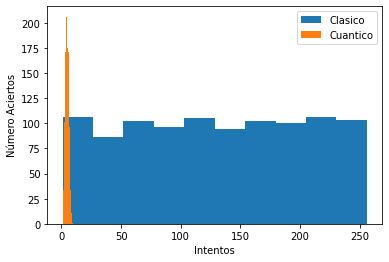

In [82]:
plt.hist(Clasico, bins=10)
plt.hist(Cuantico, bins=10)
plt.xlabel('Intentos')
plt.ylabel('Número Aciertos')
plt.legend(['Clasico', 'Cuantico'])

In [83]:
pdClassic = pd.Series(Clasico).value_counts().sort_index()
pdCuantico = pd.Series(Cuantico).value_counts().sort_index()

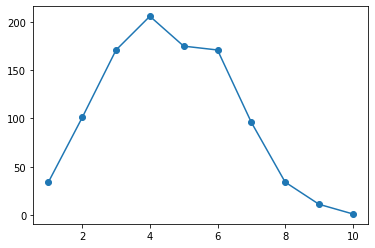

In [150]:
plt.plot(pdCuantico, '-o')
#plt.plot(pdClassic, '-o')

Para 8 qbits deberíamos haber encontrado que la mayor probabilidad es con 12 iteraciones pero 12 iteraciones da lugar a una probabilidad muy muy alta de acertar: 0.9999470421032387. La cosa es que con solo 6 iteraciones la probabilidad de acierto es de 0.5276176773084149 y con 7 mayor de 0.65 por lo que en una sola tirada no es necesario iterar tanto para obtener el resultado correcto la mayor parte de las veces!!!

In [151]:
max(Probabilities4Groover(8, Winner, 7)[0])

0.6503499947279003

In [98]:
Probabilities4Groover(NumberOfQbits, Winner, 7)

([0.0013711764912630563,
  0.0013711764912630532,
  0.0013711764912630506,
  0.0013711764912630506,
  0.0013711764912630558,
  0.001371176491263057,
  0.0013711764912630554,
  0.0013711764912630554,
  0.0013711764912630589,
  0.0013711764912630558,
  0.0013711764912630521,
  0.0013711764912630502,
  0.0013711764912630537,
  0.00137117649126306,
  0.0013711764912630563,
  0.0013711764912630563,
  0.0013711764912630543,
  0.0013711764912630543,
  0.0013711764912630513,
  0.0013711764912630513,
  0.0013711764912630554,
  0.0013711764912630563,
  0.0013711764912630543,
  0.0013711764912630543,
  0.0013711764912630558,
  0.0013711764912630537,
  0.0013711764912630513,
  0.0013711764912630513,
  0.0013711764912630554,
  0.0013711764912630574,
  0.0013711764912630537,
  0.0013711764912630537,
  0.0013711764912630513,
  0.0013711764912630532,
  0.0013711764912630513,
  0.0013711764912630502,
  0.0013711764912630537,
  0.001371176491263057,
  0.0013711764912630517,
  0.0013711764912630548,
  0.

In [152]:
print('Numero de llamdas promedio Clásico: {}'.format(np.mean(Clasico)))
print('Numero de llamdas promedio Cuantico: {}'.format(np.mean(Cuantico)))

Numero de llamdas promedio Clásico: 129.483
Numero de llamdas promedio Cuantico: 4.527


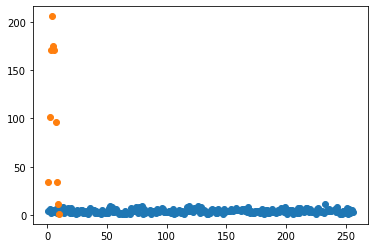

In [153]:
plt.scatter(pdClassic.index, pdClassic)
plt.scatter(pdCuantico.index, pdCuantico)

In [155]:
129**.5

11.357816691600547